# Citizens analysis

Author: Mo Al Elew

**What notebook does/produces:**

Replicates and fact checks all the data findings used in publication

**Approach:**

The general pattern includes:
1. Quote the relevant text
2. Determine asserted figure to reproduce
3. Run the operations to reproduce relevant figure
4. Assert expected value against actual value
5. Print the relevant text with the actual value templated in

Some findings cannot be directly tested using an assertion against a single value. In those cases, I display the relevant data slice, chart, or other presentation.

In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns

# Constants and helper functions

In [2]:
DATA_FP = "./outputs/citizens_auto_gis.geojson"

In [3]:
MAP_EXPORT_COLS = [
    "geo_id",
    "geo_name",
    "tot_pop",
    "density",
    "white_pct",
    "black_pct",
    "white_tot",
    "black_tot",
    "generic_location_based_premium",
    "location_effect",
    "loc_rate_div_min",
    "geometry",
]

CORRELATION_MATRIX_COLS = [
    "generic_location_based_premium",
    "black_pct",
    "white_pct",
    "density",
    "generic_location_based_premium",
]

RATE_Q_LABELS = [
    "lowest effect",
    "middle low",
    "median",
    "middle high",
    "highest effect",
]
DENSITY_Q_LABELS = [
    "lowest density",
    "middle low",
    "median",
    "middle high",
    "highest density",
]

QUANTILE_GROUP_BY_COLS = ["black_tot", "white_tot", "tot_pop"]


POP_BY_RACE_COLS = [
    "white_tot",
    "black_tot",
    "aian_tot",
    "asian_tot",
    "other_tot",
    "latin_tot",
]
POP_PCT_BY_RACE_COLS = [
    "white_pct",
    "black_pct",
    "aian_pct",
    "asian_pct",
    "other_pct",
    "latin_pct",
]

CORRELATION_COLS = [
    "generic_location_based_premium",
    "black_pct",
    "white_pct",
    "density",
    "generic_location_based_premium",
]

In [4]:
WAYNE_COUNTY_FIPS = "26163"
PROJECTED_CRS = "EPSG:3078"

INSURER = "Citizens"


def prptn_to_pct(val, precision=3):
    return round(val, precision) * 100


def calculate_racial_demograhics(df, area_name="This region"):
    white_pct = prptn_to_pct(df["white_tot"].sum() / df["tot_pop"].sum())
    black_pct = prptn_to_pct(df["black_tot"].sum() / df["tot_pop"].sum())
    print(
        f"{area_name} is {white_pct}% ({df['white_tot'].sum()} / {df['tot_pop'].sum()}) White and {black_pct}% ({df['black_tot'].sum()} / {df['tot_pop'].sum()}) Black."
    )

In [5]:
%run ../00_misc/helper-func-notebook.ipynb

# Read data

In [6]:
GDF_DATA = gpd.read_file(DATA_FP)
GDF_DATA = GDF_DATA.dropna(how="all", axis=1)
GDF_DATA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16318 entries, 0 to 16317
Data columns (total 60 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   geo_id                            16318 non-null  object  
 1   geo_name                          16318 non-null  object  
 2   tot_pop                           16318 non-null  float64 
 3   white_tot                         16318 non-null  float64 
 4   black_tot                         16318 non-null  float64 
 5   aian_tot                          16318 non-null  float64 
 6   asian_tot                         16318 non-null  float64 
 7   other_tot                         16318 non-null  float64 
 8   latin_tot                         16318 non-null  float64 
 9   white_pct                         16318 non-null  float64 
 10  black_pct                         16318 non-null  float64 
 11  aian_pct                          16318 non-nu

## Preprocess

Retain lowest rate for each geography

In [7]:
gdf_min_rate = GDF_DATA.sort_values(
    by="generic_location_based_premium"
).drop_duplicates(subset=["geo_id"], keep="first", ignore_index=True)

In [8]:
gdf = gdf_min_rate.copy()
assert (gdf["white_pct"] <= 1).all()
gdf["is_maj_white"] = gdf["white_pct"] > 0.49
gdf["is_maj_black"] = gdf["black_pct"] > 0.49

gdf["density"] = gdf["tot_pop"] / gdf.to_crs(PROJECTED_CRS).area

gdf["is_wayne_county"] = gdf["geo_id"].str.startswith(WAYNE_COUNTY_FIPS)
gdf_wayne = gdf[gdf["is_wayne_county"]]

# Location effect and race correlation

> Generally, as the proportion of Black residents increased in a Citizens territory, so did its location effect. Likewise, as the proportion of White residents in a territory increased, its location effect tended to decrease.

Correlation coefficients ranging between 0.40-0.70 are [categorized as strong for social sciences](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6107969/).

In [9]:
def calculate_correlation_coeff(df, method="pearson"):
    CORR_COEFF_ROUNDING_PRECISION = 3
    return round(
        df.corr(method=method).iloc[0, 1],
        CORR_COEFF_ROUNDING_PRECISION,
    )

,generic_location_based_premium,black_pct,white_pct,density,generic_location_based_premium
generic_location_based_premium,1.000000,0.529225,-0.524911,0.431783,1.000000
black_pct,0.529225,1.000000,-0.828121,0.539374,0.529225
white_pct,-0.524911,-0.828121,1.000000,-0.548540,-0.524911
density,0.431783,0.539374,-0.548540,1.000000,0.431783
generic_location_based_premium,1.000000,0.529225,-0.524911,0.431783,1.000000


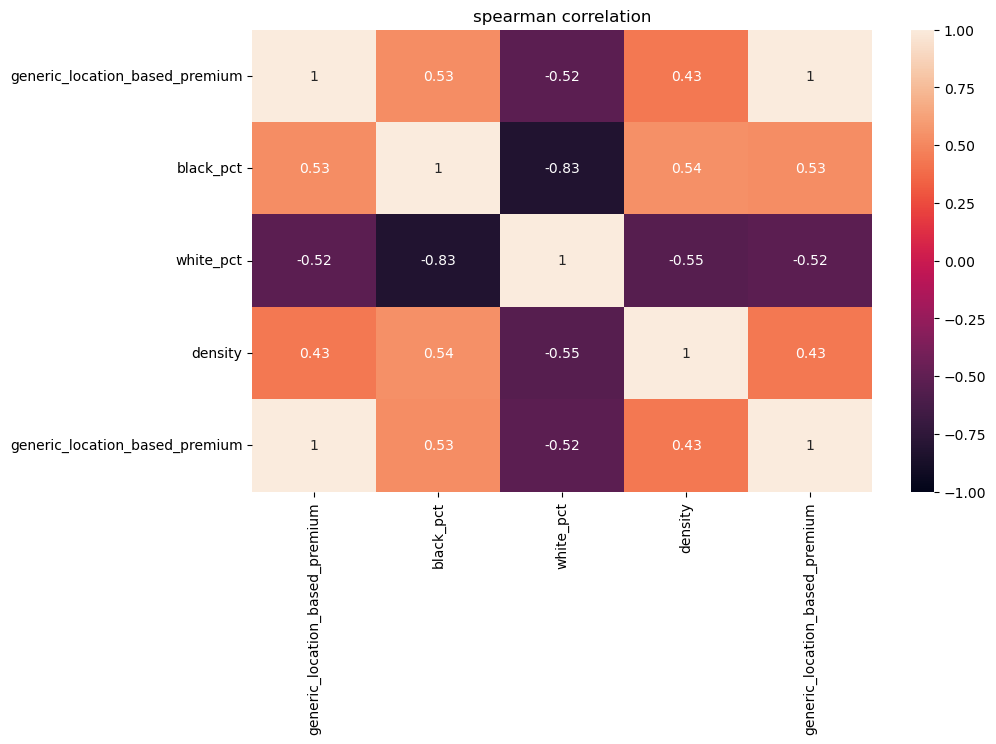

In [10]:
%run ../00_misc/helper-func-notebook.ipynb
display_correlation(gdf[CORRELATION_MATRIX_COLS], method="spearman")

In [11]:
ASSERTED_FIGURE_MIN = 0.2  # min for a non-negligible correlation coeff
ASSERTED_FIGURE_MIN_STRONG_CORR = 0.4  # min for a strong correlation coeff
black_pct_rate_corr_coeff = calculate_correlation_coeff(
    gdf[["generic_location_based_premium", "black_pct"]]
)
assert black_pct_rate_corr_coeff > ASSERTED_FIGURE_MIN
assert black_pct_rate_corr_coeff > ASSERTED_FIGURE_MIN_STRONG_CORR
f"The correlation coefficient between the Black population percentage and the location baed premium is {black_pct_rate_corr_coeff}"

'The correlation coefficient between the Black population percentage and the location baed premium is 0.731'

In [12]:
white_pct_rate_corr_coeff = calculate_correlation_coeff(
    gdf[["generic_location_based_premium", "white_pct"]]
)
assert white_pct_rate_corr_coeff < -1 * ASSERTED_FIGURE_MIN
assert white_pct_rate_corr_coeff < -1 * ASSERTED_FIGURE_MIN_STRONG_CORR
f"The correlation coefficient between the White population percentage and the location based premium is {white_pct_rate_corr_coeff}"

'The correlation coefficient between the White population percentage and the location based premium is -0.737'

# Effect quantiles


In [13]:
gdf["effect_quantile"] = pd.qcut(
    gdf["generic_location_based_premium"], q=len(RATE_Q_LABELS), labels=RATE_Q_LABELS
)
gdf["density_quantile"] = pd.qcut(
    gdf["density"], q=len(DENSITY_Q_LABELS), labels=DENSITY_Q_LABELS
)

## Race

> Fifteen percent of residents lived in territories with location effects among the top quintile of the state. Seven percent of White Michiganders and 57 percent of Black Michiganders lived in those territories.

In [14]:
gdf_groupby_quantiles = gdf.groupby("effect_quantile", observed=False)[
    QUANTILE_GROUP_BY_COLS
].sum()
df_distribution = prptn_to_pct(
    gdf_groupby_quantiles.div(gdf_groupby_quantiles.sum(axis=0), axis=1)
)
df_distribution

,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,5.3,24.8,21.6
middle low,8.0,23.9,21.3
median,9.7,23.4,21.2
middle high,20.0,21.0,21.2
highest effect,57.0,6.9,14.8


Stacker bar chart draft

In [15]:
%run ../00_misc/helper-func-notebook.ipynb
stacked_quintile_chart = stacked_race_hbar(df_distribution, "Citizens")
stacked_quintile_chart.save("../00_misc/charts/citizens_population_quintile.png")
stacked_quintile_chart

alt.Chart(...)

# Wayne County

## Location effect and race correlation

> Wayne County roughly matched the statewide trend of higher location effects, on average, for block groups with higher Black populations. The county also showed a significantly stronger trend of White block groups with lower location effects than the state as a whole.

,generic_location_based_premium,black_pct,white_pct,density,generic_location_based_premium
generic_location_based_premium,1.000000,0.691880,-0.767814,0.176738,1.000000
black_pct,0.691880,1.000000,-0.908930,0.079531,0.691880
white_pct,-0.767814,-0.908930,1.000000,-0.094022,-0.767814
density,0.176738,0.079531,-0.094022,1.000000,0.176738
generic_location_based_premium,1.000000,0.691880,-0.767814,0.176738,1.000000


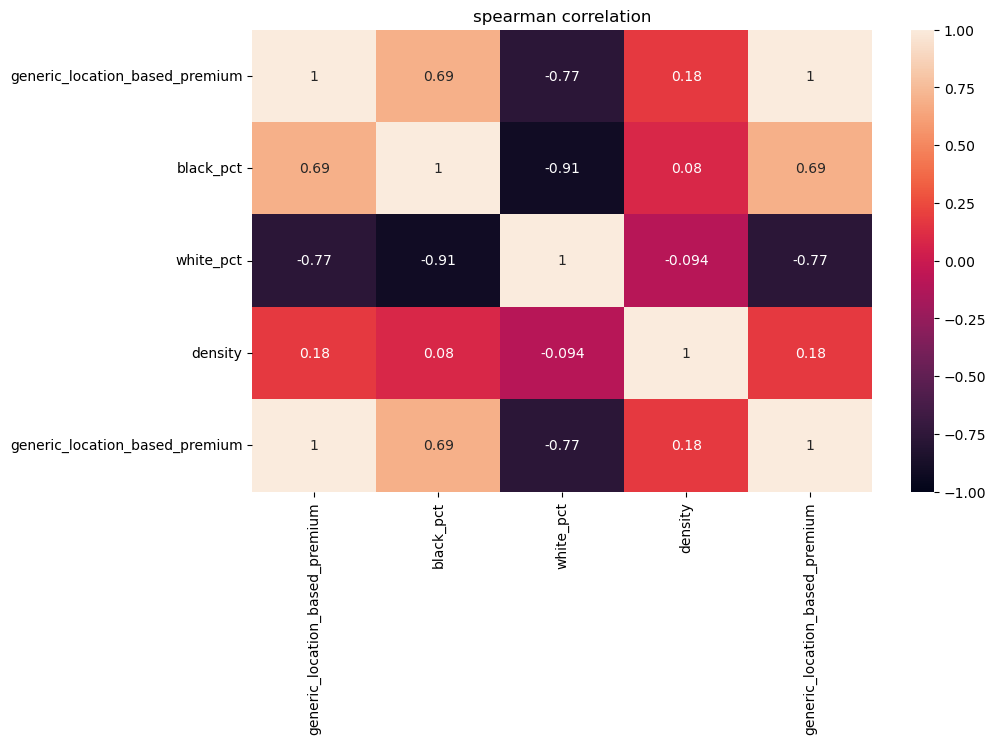

In [16]:
%run ../00_misc/helper-func-notebook.ipynb
display_correlation(gdf_wayne[CORRELATION_MATRIX_COLS], method="spearman")

## Effect quantiles

> Almost half of Wayne County’s residents lived in a territory with a location effect in the top quintile of the state. Within the county, 20 percent White residents and 85 percent of Black residents lived in one of these territories.

In [17]:
gdf_wayne_groupby_state_quantiles = (
    gdf[gdf["is_wayne_county"]]
    .groupby("effect_quantile", observed=False)[QUANTILE_GROUP_BY_COLS]
    .sum()
)
prptn_to_pct(
    gdf_wayne_groupby_state_quantiles.div(
        gdf_wayne_groupby_state_quantiles.sum(axis=0), axis=1
    )
)

,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,0.2,7.6,4.2
middle low,1.3,16.7,10.1
median,3.9,24.4,15.8
middle high,10.0,31.1,21.9
highest effect,84.7,20.2,48.0


# Nearest neighbor

In [18]:
def loc_rate_from_geo_id(geo_id, gdf=gdf):
    return gdf["geo_id"] == geo_id

In [19]:
def filter_for_neighbors(neighbors, gdf=gdf):
    return gdf[gdf["geo_id"].isin(neighbors)]

In [20]:
def filter_neighoring_rate(row, filter_func):
    gdf_neighbors = filter_for_neighbors(row, gdf=gdf)
    val = filter_func(gdf_neighbors["generic_location_based_premium"])
    geo_id = list(
        gdf_neighbors[gdf_neighbors["generic_location_based_premium"] == val]["geo_id"]
    )
    return geo_id, val

In [21]:
def min_neighboring_rate(row):
    if row["NEIGHBORS"]:
        return filter_neighoring_rate(row["NEIGHBORS"], min)
    else:
        return None

In [22]:
def neighboring_polygons(gdf):
    # add NEIGHBORS column
    gdf["NEIGHBORS"] = None

    for index, row in gdf.iterrows():

        # get 'not disjoint' geometries
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)].geo_id.tolist()

        # remove self id
        neighbors = [geo_id for geo_id in neighbors if row.geo_id != geo_id]

        # add names of neighbors as NEIGHBORS value
        gdf.at[index, "NEIGHBORS"] = neighbors  # ", ".join(neighbors)

In [23]:
gdf_neighbors = gdf.copy()
neighboring_polygons(gdf_neighbors)

neighboring_min = gdf_neighbors.apply(min_neighboring_rate, axis=1)

In [24]:
gdf_neighbors["min_geo_id"] = neighboring_min.map(
    lambda x: ",".join(x[0]) if x else None
)
gdf_neighbors["neighboring_min"] = neighboring_min.map(lambda x: x[1] if x else None)
gdf_neighbors["loc_rate_div_min"] = (
    gdf_neighbors["generic_location_based_premium"] / gdf_neighbors["neighboring_min"]
)

## Few noteworthy gaps

> There were fewer than 30 block groups that had location effects more than 50 percent higher than an adjacent block group’s location effect, so it is unlikely that a customer’s rate would be significantly different if they lived in a nearby neighborhood.

In [25]:
ASSERTED_FIGURE_MAX = 30
ASSERTED_RATIO = 1.5
actual_count = (gdf_neighbors["loc_rate_div_min"] > ASSERTED_RATIO).sum()
assert actual_count < ASSERTED_FIGURE_MAX
f"There were {actual_count} block groups that had location effects more than {ASSERTED_RATIO} times an adjacent block group’s location effect"

'There were 28 block groups that had location effects more than 1.5 times an adjacent block group’s location effect'

## Pontiac x neighboring suburbs

> For example, the northwest corner of Pontiac, Mich. showed a location effect 60 percent higher than those of its bordering suburbs.

In [26]:
ASSERTED_FIGURE = 1.6
PONTIAC_IDS = ["CTG", "CTH", "CTJ", "AHO", "CTU"]
gdf_temp = gdf_neighbors[gdf_neighbors["geography_factor_id"].isin(PONTIAC_IDS)]
assert round(gdf_temp["loc_rate_div_min"].min(), 1) >= ASSERTED_FIGURE
min_temp = round(gdf_temp["loc_rate_div_min"].min(), 2)
max_temp = round(gdf_temp["loc_rate_div_min"].max(), 2)
f"The northwest corner of Pontiac, Michigan has a location effect {min_temp}-{max_temp} times the one for suburbs bordering."

'The northwest corner of Pontiac, Michigan has a location effect 1.57-1.66 times the one for suburbs bordering.'

Display table

In [27]:
gdf_temp

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,other_tot,latin_tot,white_pct,...,geometry,is_maj_white,is_maj_black,is_wayne_county,effect_quantile,density_quantile,NEIGHBORS,min_geo_id,neighboring_min,loc_rate_div_min
7040,261251411001,Block Group 1,442.0,153.0,149.0,0.0,0.0,0.0,140.0,0.346,...,"POLYGON ((-83.30970 42.67784, -83.30936 42.678...",False,False,False,highest effect,median,"[261251435005, 261251405001, 261251411002, 261...",261251435005,27373.88,1.571559
7170,261251411002,Block Group 2,2477.0,995.0,878.0,0.0,189.0,0.0,415.0,0.402,...,"POLYGON ((-83.31466 42.67795, -83.31475 42.677...",False,False,False,highest effect,middle high,"[261251435005, 261251445002, 261251405001, 261...",261251435005,27373.88,1.643955
7299,261251409003,Block Group 3,2805.0,702.0,1919.0,14.0,12.0,20.0,138.0,0.250,...,"POLYGON ((-83.33295 42.66402, -83.33282 42.664...",False,True,False,highest effect,median,"[261251445002, 261251457001, 261251459001, 261...",261251445002,28239.02,1.637763
7327,261251409001,Block Group 1,954.0,636.0,21.0,0.0,0.0,0.0,297.0,0.667,...,"POLYGON ((-83.31043 42.64804, -83.31387 42.650...",True,False,False,highest effect,median,"[261251445002, 261251409003, 261251412002, 261...",261251445002,28239.02,1.647353
7367,261251412002,Block Group 2,1426.0,318.0,640.0,0.0,0.0,160.0,308.0,0.223,...,"POLYGON ((-83.32732 42.66852, -83.32732 42.668...",False,False,False,highest effect,middle high,"[261251445002, 261251411001, 261251411002, 261...",261251445002,28239.02,1.660436


> This corner of Pontiac is 35 percent White and 45 percent Black

> The neighboring suburbs are 89 percent White

In [28]:
calculate_racial_demograhics(gdf_temp, "The northwest corner of Pontiac")
gdf_temp_min_n = gdf_neighbors[gdf_neighbors["geo_id"].isin(gdf_temp["min_geo_id"])]
calculate_racial_demograhics(gdf_temp_min_n, "The neighboring suburbs")

The northwest corner of Pontiac is 34.599999999999994% (2804.0 / 8104.0) White and 44.5% (3607.0 / 8104.0) Black.
The neighboring suburbs is 82.3% (2955.0 / 3592.0) White and 3.5999999999999996% (129.0 / 3592.0) Black.


## Benton Harbor x St. Josepth

> In the southwest corner of Michigan, the territories east of the St. Joseph River in Benton Harbor showed location effects almost double that west of the river, in the city of St. Joseph.

In [29]:
BENTON_IDS = ["GNH", "GML", "GMQ"]
gdf_tempgdf_temp = gdf[gdf["geography_factor_id"].isin(BENTON_IDS)]

ASSERTED_FIGURE = 1.8  # defining almost twice as at least 1.8
gdf_temp = gdf_neighbors[gdf_neighbors["geography_factor_id"].isin(BENTON_IDS)]
assert round(gdf_temp["loc_rate_div_min"].min(), 1) >= ASSERTED_FIGURE
min_temp = round(gdf_temp["loc_rate_div_min"].min(), 2)
max_temp = round(gdf_temp["loc_rate_div_min"].max(), 2)
f"The territories east of the St. Joseph River in Benton Harbor showed location effects {min_temp}-{max_temp} times that west of the river, in the city of St. Joseph."

'The territories east of the St. Joseph River in Benton Harbor showed location effects 1.83-1.91 times that west of the river, in the city of St. Joseph.'

In [30]:
calculate_racial_demograhics(gdf_temp, "The Benton Harbor area")
gdf_temp_min_n = gdf_neighbors[gdf_neighbors["geo_id"].isin(gdf_temp["min_geo_id"])]
calculate_racial_demograhics(gdf_temp_min_n, "St Joseph")

The Benton Harbor area is 44.4% (1362.0 / 3065.0) White and 50.0% (1534.0 / 3065.0) Black.
St Joseph is 87.2% (2466.0 / 2829.0) White and 4.0% (114.0 / 2829.0) Black.


# Appendix

## Topline findings Section

The relevant text from the opening section of the `Findings`section

### Correlation

> We observed a strong correlation between race and location effect for Auto Club and Citizens. For both insurers, as the number of Black residents in a territory increased, the location effect tended to increase. We saw a similar but opposing trend with Michigan’s White population: As the number of White residents in a territory increased, the location effect generally decreased.

Correlation coefficients ranging between 0.40-0.70 are categorized as strong for social sciences. Results below match this.

,generic_location_based_premium,black_pct,white_pct,density,generic_location_based_premium
generic_location_based_premium,1.000000,0.529225,-0.524911,0.431783,1.000000
black_pct,0.529225,1.000000,-0.828121,0.539374,0.529225
white_pct,-0.524911,-0.828121,1.000000,-0.548540,-0.524911
density,0.431783,0.539374,-0.548540,1.000000,0.431783
generic_location_based_premium,1.000000,0.529225,-0.524911,0.431783,1.000000


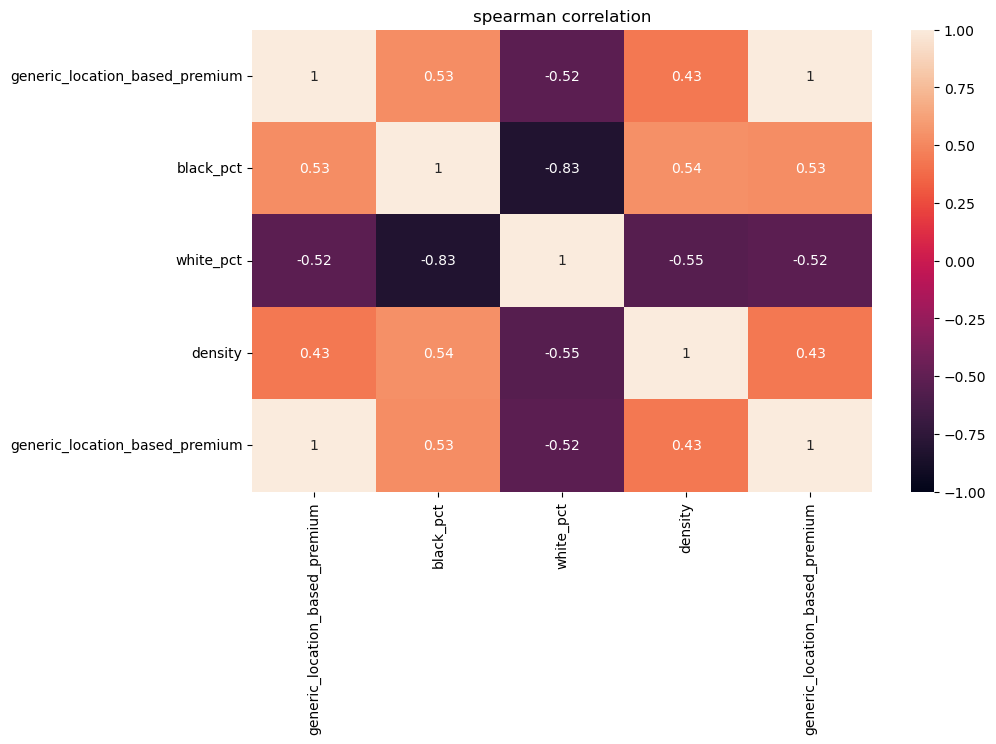

In [31]:
%run ../00_misc/helper-func-notebook.ipynb
display_correlation(gdf[CORRELATION_COLS], method="spearman")

### Rate quantiles

> For those two insurers, seven percent of White Michiganders lived in the top quintile of location effects.

In [32]:
ASSERTED_VALUE = 7
actual_value = round(df_distribution.loc["highest effect"]["white_tot"])
print(
    f"{actual_value}% of White Michiganders lived in the top quintile of location effects."
)
assert ASSERTED_VALUE == actual_value
df_distribution

7% of White Michiganders lived in the top quintile of location effects.


,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,5.3,24.8,21.6
middle low,8.0,23.9,21.3
median,9.7,23.4,21.2
middle high,20.0,21.0,21.2
highest effect,57.0,6.9,14.8


### Detroit range

In [33]:
highest_effect = gdf["location_effect"].max()
detroit_loc_effects = gdf[gdf["is_in_detroit"]]["location_effect"]
detroit_min_loc_effects = detroit_loc_effects.min()
detroit_max_loc_effects = detroit_loc_effects.max()
detroit_avg_loc_effect = round(detroit_loc_effects.mean(), 2)
assert highest_effect == detroit_max_loc_effects

print(
    f"{INSURER} range of location effects within Detroit: {detroit_min_loc_effects}-{detroit_max_loc_effects}. The avg: {detroit_avg_loc_effect}"
)
print(f"The highest effect {highest_effect} is in Detroit")

Citizens range of location effects within Detroit: 1.04-1.75. The avg: 1.52
The highest effect 1.75 is in Detroit


### Location effect and race

> Auto Club set higher location-related relativities in territories with a higher Black population and lower location-related relativities in territories with more White residents.

Display the table of distributions below

In [34]:
df_distribution

,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,5.3,24.8,21.6
middle low,8.0,23.9,21.3
median,9.7,23.4,21.2
middle high,20.0,21.0,21.2
highest effect,57.0,6.9,14.8


## Effect x density

In [35]:
def pivot_effect_density_quantiles(
    gdf, race_group, race_label=None, calculate_percent=True
):
    gdf_temp = gdf.pivot_table(
        index="effect_quantile",
        columns="density_quantile",
        values=race_group,
        aggfunc="sum",
        observed=False,
    )
    if calculate_percent:
        gdf_temp = prptn_to_pct(gdf_temp / gdf_temp.sum().sum())
    gdf_temp = gdf_temp.reset_index()
    if race_label:
        gdf_temp["race"] = race_label
    else:
        gdf_temp["race"] = race_group
    gdf_temp["insurer"] = INSURER
    return gdf_temp


def join_effect_density_quantiles_pivots(calculate_percent=True):
    gdf_white = pivot_effect_density_quantiles(
        gdf, "white_tot", "White", calculate_percent=calculate_percent
    )
    gdf_black = pivot_effect_density_quantiles(
        gdf, "black_tot", "Black", calculate_percent=calculate_percent
    )
    return pd.concat([gdf_white, gdf_black], ignore_index=True)


gdf_effect_density_quantiles_pivot = join_effect_density_quantiles_pivots()
gdf_effect_density_quantiles_pivot.to_csv(
    "./outputs/effect_density_quantiles_pivot.csv", index=False
)
gdf_effect_density_quantiles_pivot = join_effect_density_quantiles_pivots(False)
gdf_effect_density_quantiles_pivot.to_csv(
    "./outputs/effect_density_quantiles_pivot_count.csv", index=False
)

In [36]:
gdf_temp = gdf.pivot_table(
    index="effect_quantile", columns="density_quantile", aggfunc="count", observed=False
)["black_pct"]
df_density_quintile = round(gdf_temp / gdf_temp.sum(), 3)
df_density_quintile

density_quantile,lowest density,middle low,median,middle high,highest density
effect_quantile,,,,,
lowest effect,0.217,0.329,0.248,0.143,0.062
middle low,0.303,0.257,0.182,0.145,0.114
median,0.367,0.219,0.155,0.139,0.119
middle high,0.103,0.150,0.235,0.271,0.241
highest effect,0.010,0.045,0.180,0.302,0.463


In [37]:
%run ../00_misc/helper-func-notebook.ipynb
df_income_quintile = prptn_to_pct(gdf_temp / gdf_temp.sum(), 5)
density_hbar = stacked_population_density_hbar(df_density_quintile, title="Citizens")
density_hbar

alt.Chart(...)

## Density and race

In [38]:
gdf_groupby_density_quantiles = gdf.groupby("density_quantile", observed=False)[
    QUANTILE_GROUP_BY_COLS
].sum()
gdf_groupby_density_quantiles

,black_tot,white_tot,tot_pop
density_quantile,,,
lowest density,19403.0,1697643.0,1807460.0
middle low,111897.0,2000205.0,2279223.0
median,250296.0,1489181.0,1961884.0
middle high,378661.0,1173295.0,1758856.0
highest density,586654.0,1033807.0,1878334.0


In [39]:
column_sums = gdf_groupby_density_quantiles.sum(axis=0)
df_density_distribution = prptn_to_pct(
    gdf_groupby_density_quantiles.div(column_sums, axis=1), 2
)
df_density_distribution

,black_tot,white_tot,tot_pop
density_quantile,,,
lowest density,1.0,23.0,19.0
middle low,8.0,27.0,24.0
median,19.0,20.0,20.0
middle high,28.0,16.0,18.0
highest density,44.0,14.0,19.0


## Effect in top quantile

In [40]:
gdf_highest_effects = gdf[gdf["effect_quantile"] == "highest effect"]
lowest_quantile_min_effect = gdf_highest_effects["location_effect"].min()
highest_quantile_max_effect = gdf_highest_effects["location_effect"].max()

print(
    f"The location effect in the top quantile ranged from {lowest_quantile_min_effect} to {highest_quantile_max_effect}"
)

The location effect in the top quantile ranged from 1.15 to 1.75


## Export data

In [41]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_race_distribution(df_distribution, "Citizens")
df_export.to_csv("./outputs/citizens_race_chart_data.csv")

In [42]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_race_distribution(df_density_distribution, "Citizens")
df_export.to_csv("./outputs/citizens_race_density_chart_data.csv")

In [43]:
%run ../00_misc/helper-func-notebook.ipynb
df_export = datawrapper_pop_density_distribution(df_density_quintile, "Citizens")
df_export.to_csv("./outputs/citizens_pop_density_chart_data.csv")
df_export

Population density,lowest effect,middle low,median,middle high,highest effect,Insurer
Lowest density,0.217,0.303,0.367,0.103,0.010,Citizens
Lower density,0.329,0.257,0.219,0.150,0.045,Citizens
Middle density,0.248,0.182,0.155,0.235,0.180,Citizens
Higher density,0.143,0.145,0.139,0.271,0.302,Citizens
Highest density,0.062,0.114,0.119,0.241,0.463,Citizens


In [44]:
gdf_neighbors[MAP_EXPORT_COLS].to_file(
    "../00_misc/map_files/citizens_auto_clean.geojson"
)

## Market discount code effect 

This was cut from the final draft, but I am retaining for reference.

> A customer could see their location effect almost quadruple solely based on the location effect relativity assigned to their market discount code. 

Group by market discount code and caclulte the ration between the lower bound and upper bound discount code group

In [45]:
gdf_temp = GDF_DATA.pivot(
    index="geo_id",
    columns=["uw_market_discount_code"],
    values="generic_location_based_premium",
)
gdf_temp["div"] = gdf_temp["0000001-0059999"] / gdf_temp["0060000-0099999"]
gdf_temp = gdf_temp.sort_values("div")
gdf_temp

uw_market_discount_code,0000001-0059999,0060000-0099999,div
geo_id,,,
260210008002,16407.10,29876.96,0.549156
261590104002,19696.94,34961.98,0.563382
260210009002,16112.04,28192.52,0.571501
260210008003,17046.24,29699.28,0.573961
260210013001,16449.06,28388.06,0.579436
...,...,...,...
261635113001,182536.74,52170.62,3.498842
261635113003,185825.42,52887.82,3.513577
261635105003,186101.28,51874.02,3.587562


In [46]:
ASSERTED_FIGURE = 4
max_ratio = max(
    (gdf_temp["0000001-0059999"] / gdf_temp["0060000-0099999"]).max(),
    (gdf_temp["0060000-0099999"] / gdf_temp["0000001-0059999"]).max(),
)
assert round(max_ratio) == ASSERTED_FIGURE, f"{max_ratio} != {ASSERTED_FIGURE}"
f"A customer could see their location effect go up by {max_ratio}x solely based on the location effect relativity assigned to their market discount code. "

'A customer could see their location effect go up by 3.6826207354596825x solely based on the location effect relativity assigned to their market discount code. '

## Exclude Detroit

Keep the same quintile

Recalculate quintiles

In [47]:
gdf_exclude_detroit = gdf[~gdf["is_in_detroit"]].copy()
gdf_exclude_detroit["effect_quantile"] = pd.qcut(
    gdf_exclude_detroit["generic_location_based_premium"],
    q=len(RATE_Q_LABELS),
    labels=RATE_Q_LABELS,
)
gdf["density_quantile"] = pd.qcut(
    gdf_exclude_detroit["density"], q=len(DENSITY_Q_LABELS), labels=DENSITY_Q_LABELS
)

gdf_groupby_quantiles = gdf_exclude_detroit.groupby("effect_quantile", observed=False)[
    QUANTILE_GROUP_BY_COLS
].sum()
column_sums = gdf_groupby_quantiles.sum(axis=0)
df_distribution = prptn_to_pct(gdf_groupby_quantiles.div(column_sums, axis=1), 3)
df_distribution

,black_tot,white_tot,tot_pop
effect_quantile,,,
lowest effect,7.1,22.5,20.7
middle low,10.5,21.2,19.9
median,11.9,21.4,20.2
middle high,21.5,20.0,20.6
highest effect,48.9,14.9,18.6
